<a href="https://colab.research.google.com/github/Sompote/RIC_transformer/blob/main/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install -q --upgrade keras-nlp

In [238]:
#Transformer prediciton to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

#import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Flatten, concatenate,Reshape, Dropout,Bidirectional,LayerNormalization
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from keras.metrics import MeanAbsolutePercentageError
from keras import *
from keras.optimizers import Adam
import keras_nlp

df = pd.read_excel('/content/drive/MyDrive/RIC/data_17aug.xlsx')
data=np.array(df)
X=data[:,1:29]
Y=data[:,34:62]
x_featured=data[:,29:32]


In [239]:
transformer = models.load_model('/content/drive/MyDrive/RIC/train_model/model1/transformer_medium_final.h5')

In [212]:
transformer.summary()

Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 LSTM_input (InputLayer)     [(None, 28, 4)]              0         []                            
                                                                                                  
 CNN_input (InputLayer)      [(None, 28, 4)]              0         []                            
                                                                                                  
 layer_normalization_10 (La  (None, 28, 4)                8         ['LSTM_input[0][0]']          
 yerNormalization)                                                                                
                                                                                                  
 position_embedding_2 (Posi  (None, 28, 4)                112       ['CNN_input[0][0]'] 

In [240]:
import pickle #download weight scaler
scaler_x = pickle.load(open('/content/drive/MyDrive/RIC/train_model/model_final/scaler_x-2.pkl', 'rb'))
scaler_y = pickle.load(open('/content/drive/MyDrive/RIC/train_model/model_final/scaler_y-3.pkl', 'rb'))
scaler_f = pickle.load(open('/content/drive/MyDrive/RIC/train_model/model_final/scaler_f-2.pkl', 'rb'))

In [244]:
#prepare data
#feature=np.array([50,18,0.5])
#feature=np.reshape(feature,(1,-1))
sample=30
Xd=X[sample-1:sample]
feature=x_featured[sample-1:sample]

x_train = scaler_x.transform(Xd)
x_feature=scaler_f.transform(feature)
y_ini=np.zeros((1,28))
y_ini[0,0]=0
#y_ini=scaler_y.transform(y_ini)

def CNN_tensor(X,X_feature):
  X_train_CNN=np.zeros((X.shape[0],X.shape[1],X_feature.shape[1]+1))
  X_train_CNN[:,:,0]=x_train
  for i in range(0,(X.shape[0])):
    X_train_CNN[i,:,1]=x_feature[i,0]
    X_train_CNN[i,:,2]=x_feature[i,1]
    X_train_CNN[i,:,3]=x_feature[i,2]
  return X_train_CNN
X_cnn=CNN_tensor(x_train,x_feature)


In [245]:
for step in range(0,27):
  y=transformer.predict([x_feature,X_cnn, X_cnn,y_ini])
  y_ini[0,step+1]=y

y_pred=scaler_y.inverse_transform(y_ini)


1/1 [==============================] - 0s 59ms/step


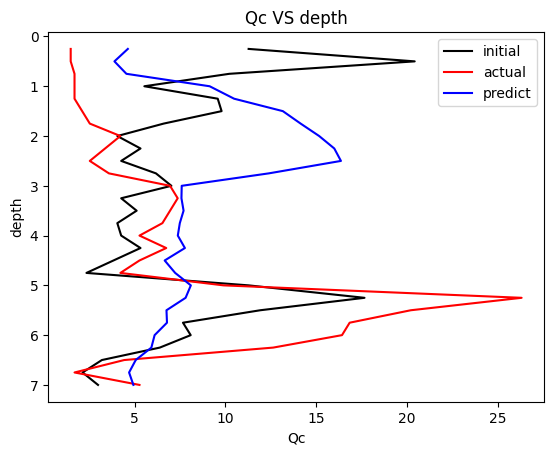

In [246]:
import matplotlib.pyplot as plt

# Define the x-axis and corresponding y-axis values as lists

ydist=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.25,6.5,6.75,7]


# Plot them on canvas using plt.plot() function
plt.plot(X[sample-1], ydist,color='black',label='initial')
plt.plot(Y[sample-1], ydist,color='red',label='actual')
plt.plot(y_pred[0], ydist,color='blue',label='predict')
plt.legend()


# Give a name to x-axis and y-axis using plt.xlabel() and plt.ylabel() functions
plt.xlabel("Qc")
plt.ylabel("depth")

# Give a title to your plot using plt.title() function
plt.title("Qc VS depth")
# Get the current axes instance
ax = plt.gca()

# Invert the y-axis
ax.invert_yaxis()

# Finally, to view your plot, we use plt.show() function
plt.show()

In [232]:
np.savetxt('array5.csv', y_pred, delimiter=',')